# Test for Simulated EEG

**Author**: Guillaume Dumas  
**Date**: 2020-07-09

## Overview

This notebook demonstrates a simulation of EEG data using coupled oscillators. In this example:

- We load simulated EEG epochs using MNE.
- Random epochs are generated for comparison.
- Coupled oscillators are simulated by integrating a system of differential equations (using `odeint`).
- We define a function to generate a virtual dyad from the simulated data.

The final output is a set of simulated epochs that are plotted and can be further analyzed using HyPyP's tools.

## Load useful libs

In [1]:
# Core libraries
from pathlib import Path
from copy import copy
from collections import OrderedDict

# Data science libraries
import numpy as np
import scipy
from scipy.integrate import odeint

# Visualization
import matplotlib.pyplot as plt

# MNE for EEG processing
import mne

# HyPyP modules
from hypyp import prep  # requires autoreject installation
from hypyp import analyses
from hypyp import stats
from hypyp import viz
from hypyp import utils

print('All libraries imported.')

All libraries imported.


## Setting Parameters

We define the frequency bands used in the study and store them in an `OrderedDict` to maintain the desired order.

In [2]:
# Define frequency bands
freq_bands = {
    'Theta': [4, 7],
    'Alpha-Low': [7.5, 11],
    'Alpha-High': [11.5, 13],
    'Beta': [13.5, 29.5],
    'Gamma': [30, 48]
}

# Preserve the order using an OrderedDict
freq_bands = OrderedDict(freq_bands)

print('Frequency bands set:', freq_bands)

Frequency bands set: OrderedDict([('Theta', [4, 7]), ('Alpha-Low', [7.5, 11]), ('Alpha-High', [11.5, 13]), ('Beta', [13.5, 29.5]), ('Gamma', [30, 48])])


## Load Data

We load the EEG epochs from fiff files for two participants. The epochs are then equalized so that both participants have the same number of epochs.

In [3]:
# Load epochs from fiff files (using MNE)
epo1 = mne.read_epochs(
    Path('../data/participant1-epo.fif').resolve(),
    preload=True
)

epo2 = mne.read_epochs(
    Path('../data/participant2-epo.fif').resolve(),
    preload=True
)

print('Epochs loaded for both participants.')

Reading /home/patrice/work/ppsp/HyPyP-xdf/data/participant1-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Reading /home/patrice/work/ppsp/HyPyP-xdf/data/participant2-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Epochs loaded for both participants.


Since our example dataset was not initially dedicated to hyperscanning, we need to equalize the number of epochs between our two participants.

In [4]:
# Equalize the number of epochs between participants
mne.epochs.equalize_epoch_counts([epo1, epo2])
print('Epoch counts equalized.')

Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

In [5]:
# Define the sampling frequency from the first participant's data
sampling_rate = epo1.info['sfreq']  # in Hz
print('Sampling rate:', sampling_rate)

Sampling rate: 500.0


## Generate Random Epochs

Using HyPyP's utility functions, we merge the two participants' epochs and then generate a set of random epochs for comparison.

In [6]:
# Merge epochs from both participants
epo_real = utils.merge(epoch_S1=epo1, epoch_S2=epo2)

# Generate random epochs with a specified mean and standard deviation
epo_rnd = utils.generate_random_epoch(epoch=epo_real, mu=0.0, sigma=2.0)

# Get data shape and sampling frequency
n_epo, n_chan, n_samp = epo_real.get_data(copy=False).shape
sfreq = epo_real.info['sfreq']

print(f'epo_real shape: {n_epo} epochs, {n_chan} channels, {n_samp} samples per epoch')

Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
epo_real shape: 36 epochs, 62 channels, 501 samples per epoch


## Generate Coupled Oscillators

We now simulate coupled oscillators. First, we define the parameters for the oscillators and construct a coupling matrix `W` that specifies which channels are coupled. In this example, the channels are split into two groups of equal size, with intra-group coupling only.

We then visualize the coupling matrix using `matshow`.

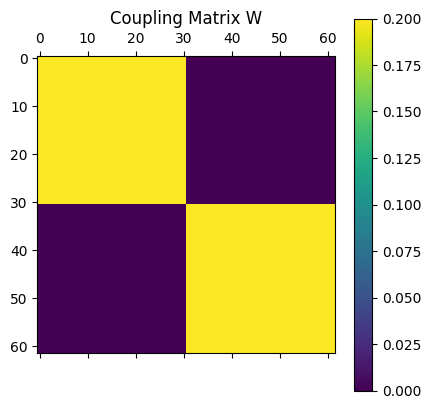

Coupling matrix constructed.


In [7]:
# Oscillator parameters
frequency_mean = 10.0  # Hz
frequency_std = 0.2    # Hz

noise_phase_level = 0.005 / n_samp
noise_amplitude_level = 0.0

# Determine the number of channels per group
N = int(n_chan / 2)

# Build the coupling matrix with two groups
A11 = 1 * np.ones((N, N))
A12 = 0 * np.ones((N, N))
A21 = 0 * np.ones((N, N))
A22 = 1 * np.ones((N, N))
W = np.block([[A11, A12], [A21, A22]])
W = 0.2 * W

# Visualize the coupling matrix
plt.matshow(W)
plt.title('Coupling Matrix W')
plt.colorbar()
plt.show()

print('Coupling matrix constructed.')

### Simulate Oscillator Phases

We simulate the phases of the coupled oscillators by integrating a system of differential equations. First, we define the function `fp(p, t)` which computes the instantaneous phase derivative given the current phase `p` and time `t`.

We then integrate this function using `odeint` over a time vector `tv` and plot the phase evolution at the start and end of the simulation.

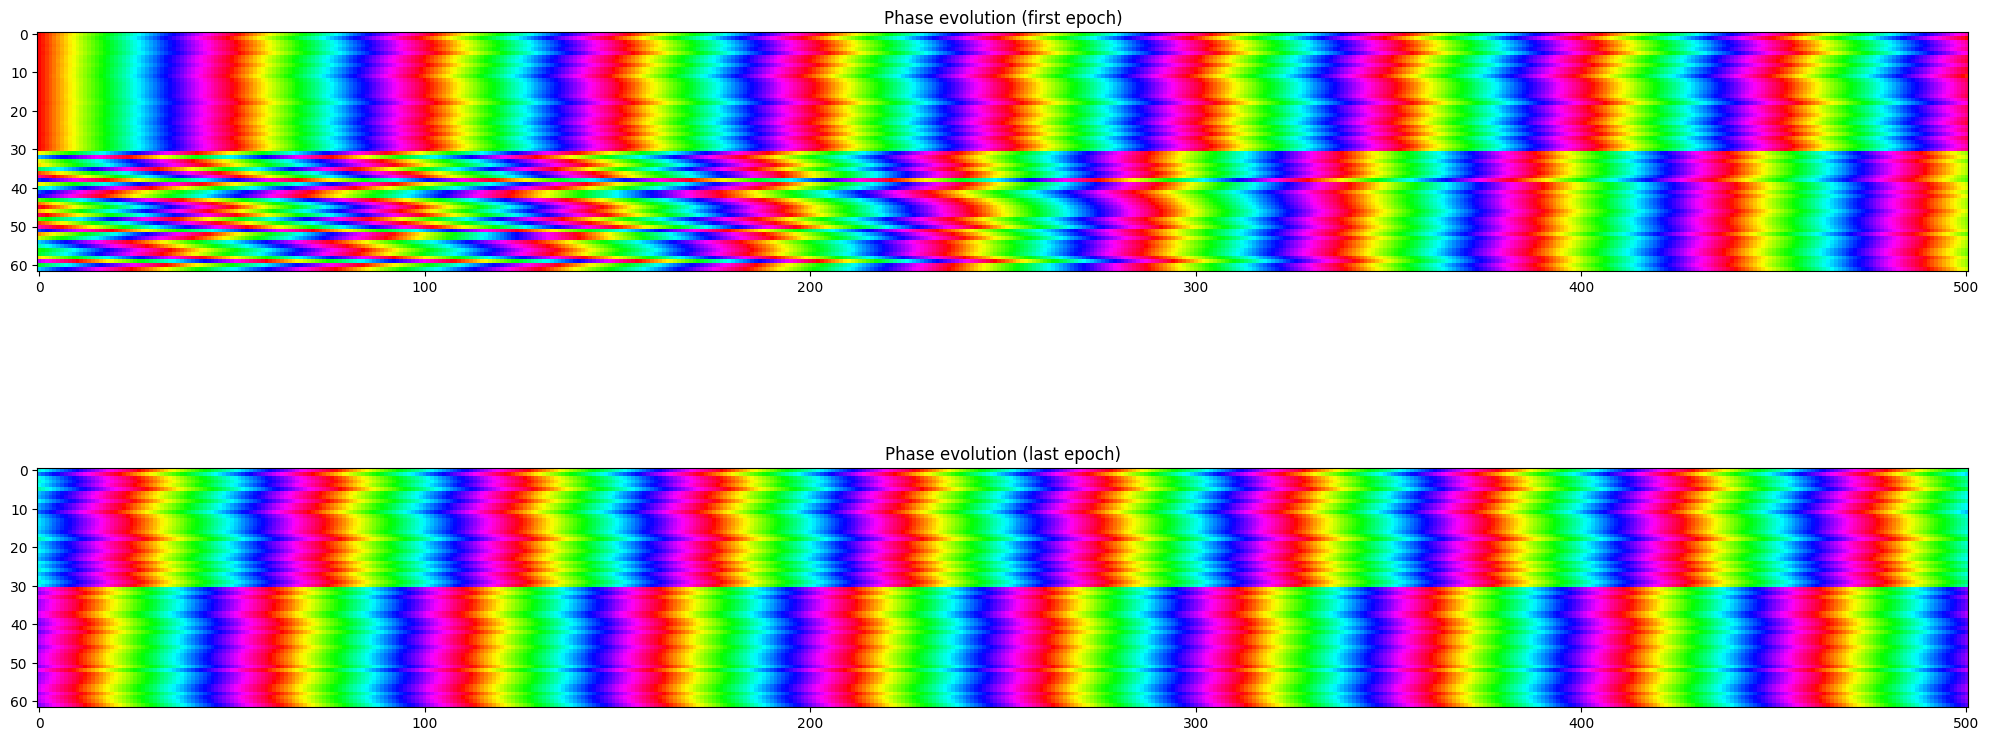

Phase simulation completed.


In [8]:
# Total number of time points across all epochs
Nt = n_samp * n_epo

# Total duration in seconds
tmax = (n_samp / sfreq) * n_epo

# Create a time vector from 0 to tmax
tv = np.linspace(0., tmax, Nt)

# Generate random frequencies for each channel
freq = frequency_mean + frequency_std * np.random.randn(n_chan)
omega = 2. * np.pi * freq

def fp(p, t):
    """
    Compute the derivative of the phase vector for the coupled oscillators.
    
    Parameters:
        p (array): Phase vector (in radians).
        t (float): Time (not used explicitly here as the system is autonomous).
    
    Returns:
        array: Time derivative of phase vector.
    """
    p = np.atleast_2d(p)
    # Compute coupling term
    coupling = np.squeeze((np.sin(p) * np.matmul(W, np.cos(p).T).T) - (np.cos(p) * np.matmul(W, np.sin(p).T).T))
    # Compute phase derivative
    dotp = omega - coupling + noise_phase_level * np.random.randn(n_chan)
    return dotp

# Integrate the differential equation to obtain phase evolution
p0 = 2 * np.pi * np.block([np.zeros(N), np.zeros(N) + np.random.rand(N) + 0.5])
Phi = odeint(fp, p0, tv) % (2 * np.pi)

# Plot phase evolution for the first epoch and the last epoch
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.imshow(Phi[:n_samp, :].T, interpolation='none', cmap='hsv')
plt.title('Phase evolution (first epoch)')
plt.subplot(2, 1, 2)
plt.imshow(Phi[-n_samp:, :].T, interpolation='none', cmap='hsv')
plt.title('Phase evolution (last epoch)')
plt.tight_layout()
plt.show()

print('Phase simulation completed.')

### Plot Signals

We now compare the original EEG epochs, the random signal, and the simulated sine signals computed from the phase evolution. Four subplots are generated for visualization.

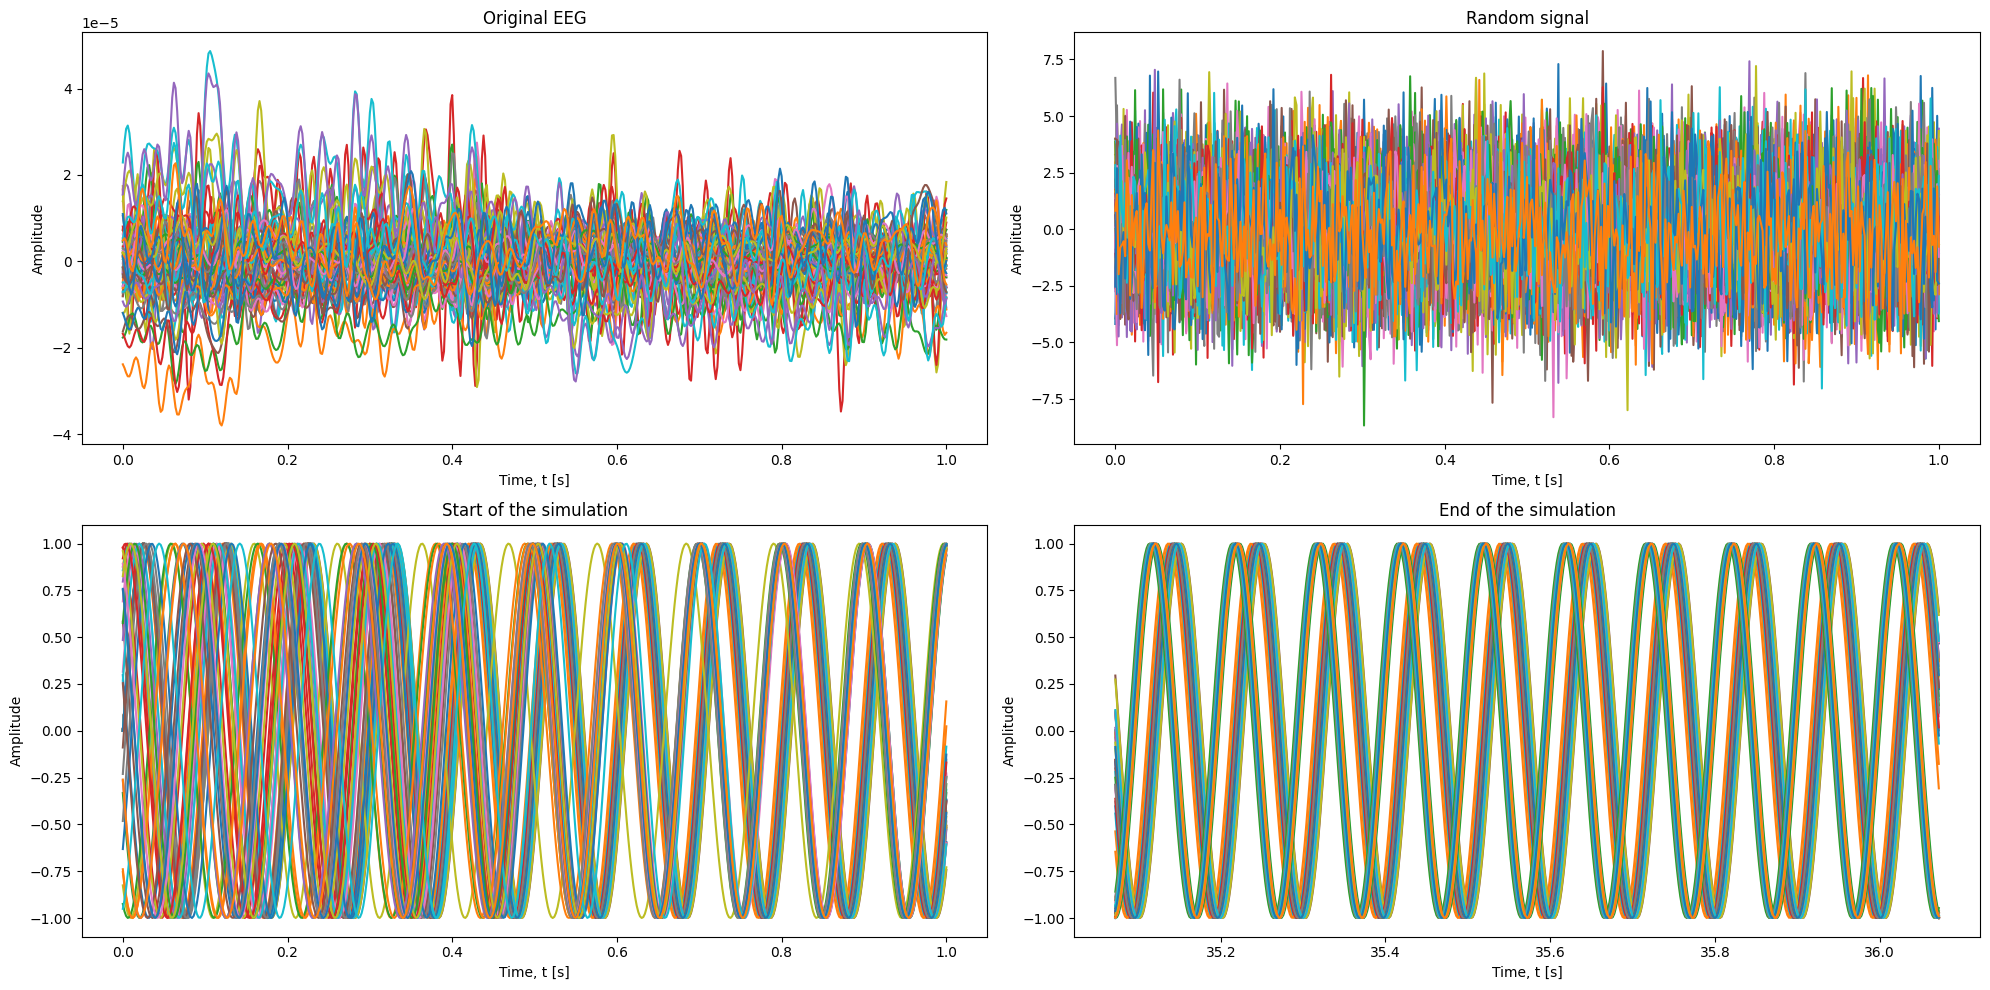

Signal plots generated.


In [9]:
plt.figure(figsize=(20, 10))

# Plot original EEG (first epoch from merged real data)
plt.subplot(2, 2, 1)
plt.plot(tv[:n_samp], np.squeeze(epo_real[0]._data.T), "-")
plt.xlabel("Time, t [s]")
plt.ylabel("Amplitude")
plt.title('Original EEG')

# Plot random signal (first epoch from random data)
plt.subplot(2, 2, 2)
plt.plot(tv[:n_samp], np.squeeze(epo_rnd[0]._data).T, "-")
plt.xlabel("Time, t [s]")
plt.ylabel("Amplitude")
plt.title('Random signal')

# Plot sine of phase at start of simulation
plt.subplot(2, 2, 3)
plt.plot(tv[:n_samp], np.sin(Phi[:n_samp, :]), "-")
plt.xlabel("Time, t [s]")
plt.ylabel("Amplitude")
plt.title('Start of the simulation')

# Plot sine of phase at end of simulation
plt.subplot(2, 2, 4)
plt.plot(tv[-n_samp:], np.sin(Phi[-n_samp:, :]), "-")
plt.xlabel("Time, t [s]")
plt.ylabel("Amplitude")
plt.title('End of the simulation')

plt.tight_layout()
plt.show()

print('Signal plots generated.')

## Generate Virtual Dyad

We define a function `virtual_dyad` that creates simulated EEG epochs based on the real epochs using coupled oscillator dynamics. The function integrates the phase equations and then creates simulated EEG signals as sine waves with added noise.

Below is the function definition with a docstring describing its inputs and outputs.

In [10]:
def virtual_dyad(epochs=epo_real, frequency_mean=10., frequency_std=0.2, noise_phase_level=0.005, noise_amplitude_level=0.1, W=W):
    """
    Generate a simulated (virtual) dyad of EEG epochs based on coupled oscillator dynamics.
    
    Parameters:
        epochs (Epochs): Real EEG epochs to base the simulation on.
        frequency_mean (float): Mean oscillator frequency (Hz).
        frequency_std (float): Standard deviation of oscillator frequencies (Hz).
        noise_phase_level (float): Noise level added to phase dynamics.
        noise_amplitude_level (float): Amplitude noise level added to the simulated EEG.
        W (ndarray): Coupling matrix between channels.
    
    Returns:
        Epochs: Simulated EEG epochs with the same structure as the input epochs.
    """
    n_epo, n_chan, n_samp = epochs.get_data(copy=False).shape
    sfreq = epochs.info['sfreq']

    Nt = n_samp * n_epo
    tmax = (n_samp / sfreq) * n_epo  # total duration in seconds
    tv = np.linspace(0., tmax, Nt)

    # Generate random oscillator frequencies for each channel
    freq = frequency_mean + frequency_std * np.random.randn(n_chan)
    omega = 2. * np.pi * freq

    def fp(p, t):
        p = np.atleast_2d(p)
        coupling = np.squeeze((np.sin(p) * np.matmul(W, np.cos(p).T).T) - (np.cos(p) * np.matmul(W, np.sin(p).T).T))
        dotp = omega - coupling + noise_phase_level * np.random.randn(n_chan) / n_samp
        return dotp

    # Initial phases
    p0 = 2 * np.pi * np.block([np.zeros(int(n_chan/2)), np.zeros(int(n_chan/2)) + np.random.rand(int(n_chan/2)) + 0.5])

    # Integrate phase dynamics
    phi = odeint(fp, p0, tv) % (2 * np.pi)
    
    # Create simulated EEG signals as sine of the phases plus amplitude noise
    eeg = np.sin(phi) + noise_amplitude_level * np.random.randn(*phi.shape)
    
    # Reshape the simulated data to match the original epochs shape
    simulation = epochs.copy()
    simulation._data = np.transpose(np.reshape(eeg.T, [n_chan, n_epo, n_samp]), (1, 0, 2))
    
    return simulation

print('virtual_dyad function defined.')

virtual_dyad function defined.


## Simulate and Plot Virtual Dyad

We now generate simulated EEG epochs using the `virtual_dyad` function and plot a subset of the epochs.

Using matplotlib as 2D backend.


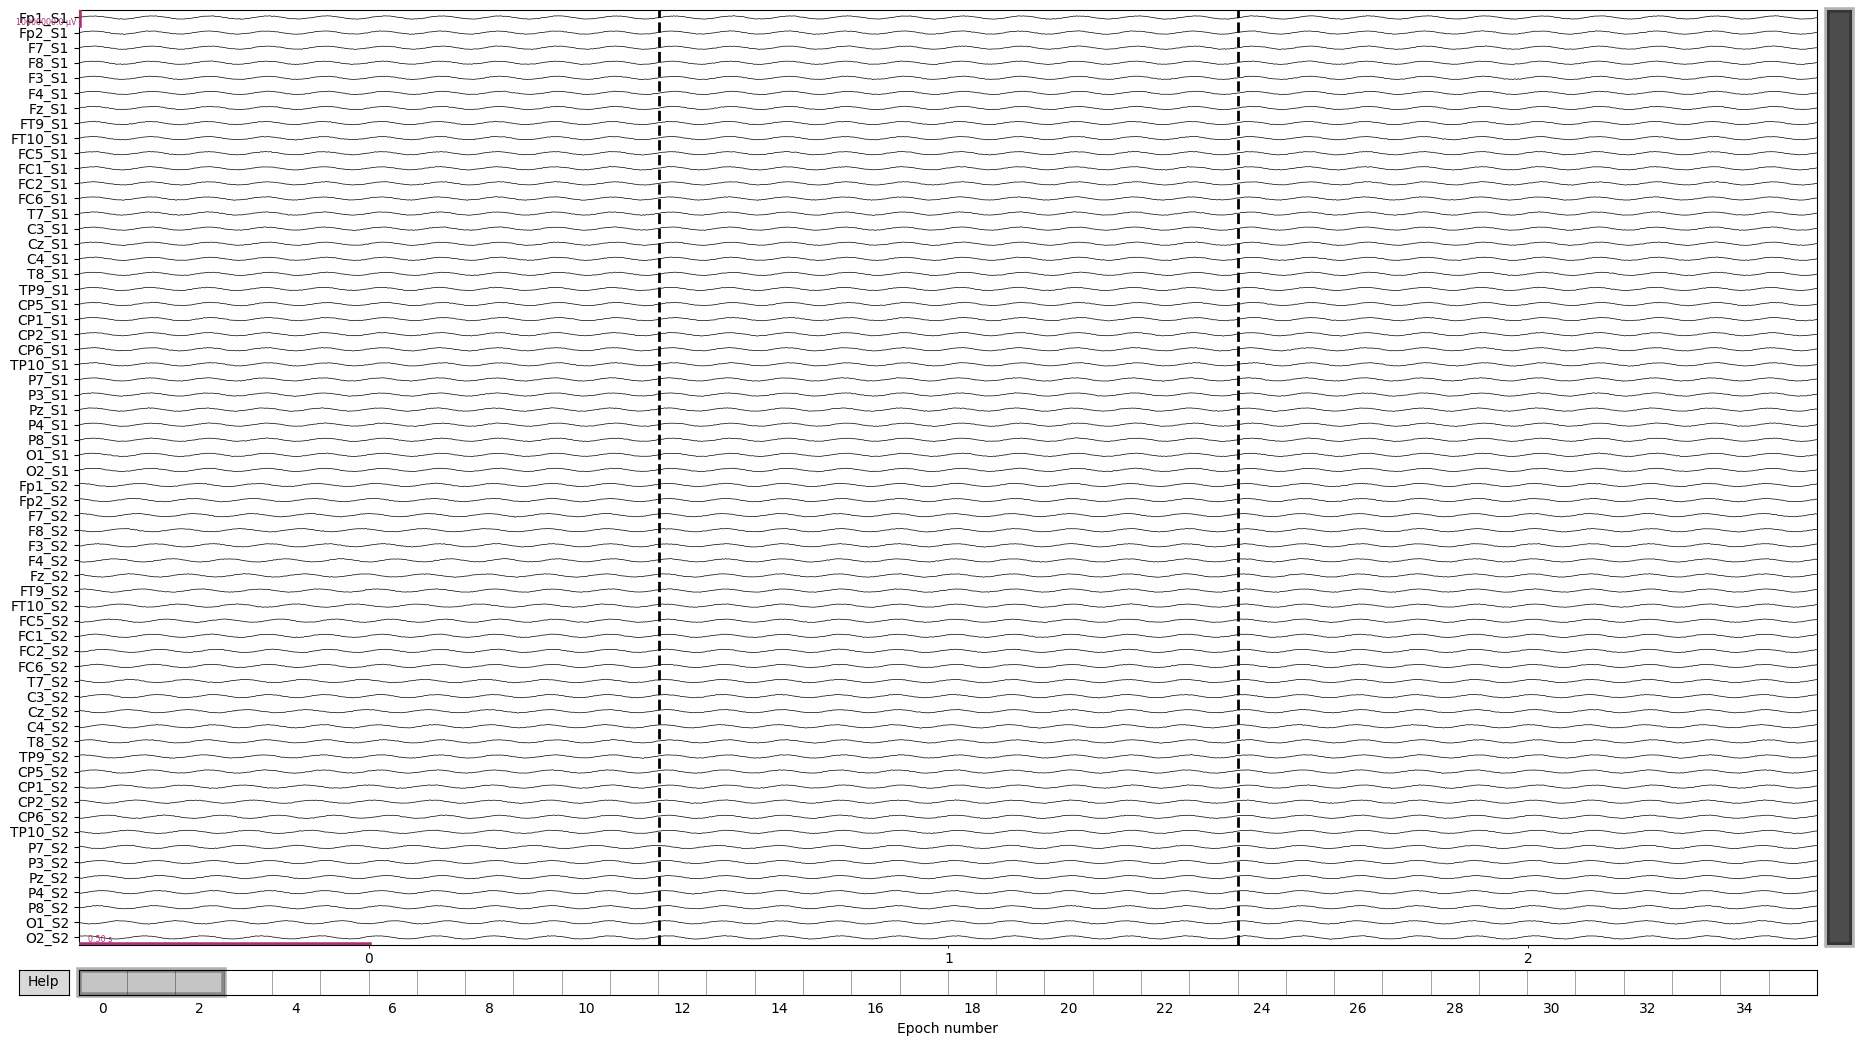

Simulated EEG (virtual dyad) plotted.


In [11]:
# Generate simulated epochs based on the real epochs
sim = virtual_dyad(epochs=epo_real, frequency_mean=10., frequency_std=0.2, noise_phase_level=0.005, noise_amplitude_level=0.1, W=W)

# Plot a few epochs from the simulated data
sim.plot(scalings=5, n_epochs=3, n_channels=62)
plt.show()

print('Simulated EEG (virtual dyad) plotted.')